In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import joblib
import torch.optim as optim
from visual_utils import plot_learning_curve

In [2]:
df = pd.read_csv("data_cleaned_v_2.csv")
scaler = joblib.load("scaler_new_v_0_0_2.save")

In [33]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

X = df.drop('price', axis=1).values 
y = df['price'].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

# Create the model
model = NeuralNetwork(input_size, hidden_size, output_size)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 
num_epochs = 100
batch_size = int(0.01 * len(df_nonans))  # Set the batch size
train_losses = []  # List to store training losses
test_losses = []   # List to store test losses

/tmp/ipykernel_3217/2546592206.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_3217/2546592206.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Epoch [1/100], Training Loss: 1377886.5338230068, Test Loss: 14636.6904296875
Epoch [2/100], Training Loss: 1247594.4120364885, Test Loss: 14634.2978515625
Epoch [3/100], Training Loss: 1247224.6454211585, Test Loss: 14630.4697265625
Epoch [4/100], Training Loss: 1246779.5943608577, Test Loss: 14626.1279296875
Epoch [5/100], Training Loss: 1246214.3580144532, Test Loss: 14620.2919921875
Epoch [6/100], Training Loss: 1245527.2181021206, Test Loss: 14614.6572265625
Epoch [7/100], Training Loss: 1244576.6539509536, Test Loss: 14606.1396484375
Epoch [8/100], Training Loss: 1243287.2285274256, Test Loss: 14594.578125
Epoch [9/100], Training Loss: 1241445.0600639735, Test Loss: 14577.46875
Epoch [10/100], Training Loss: 1238665.2609880345, Test Loss: 14554.46484375
Epoch [11/100], Training Loss: 1233729.4439047505, Test Loss: 14510.6328125
Epoch [12/100], Training Loss: 1223960.8079611422, Test Loss: 14431.4150390625
Epoch [13/100], Training Loss: 1201059.3607392488, Test Loss: 14219.5625
Ep

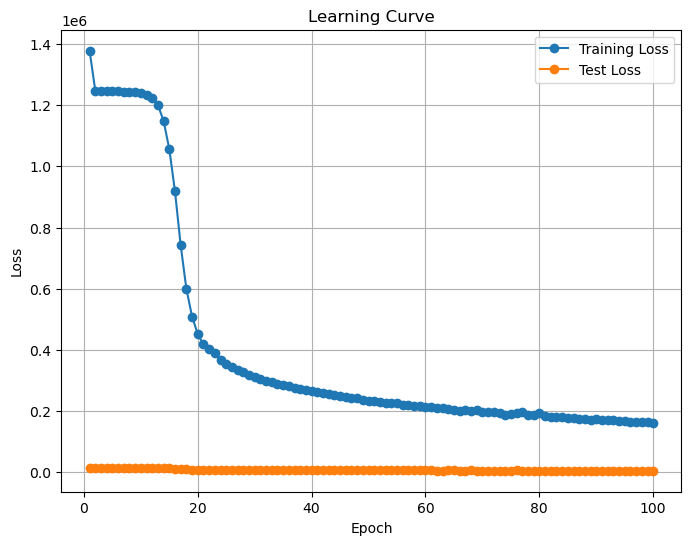

In [34]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_X)  # Forward pass
        loss = (criterion(outputs, batch_y.view(-1, 1)))  # Calculate the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    # Calculate test loss
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        test_loss = (criterion(test_outputs, y_test.view(-1, 1)))
        rmse = torch.sqrt(test_loss) 
        model.train()

    # Append losses to lists
    train_losses.append(epoch_loss / len(X_train))
    test_losses.append(rmse.item())

    # Print the average loss for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')
# After training, you can use the lists to plot the learning curve
plot_learning_curve(train_losses, test_losses)

In [15]:
data = transform_raw_input_to_df("Opel", "Insignia", "2.0D", 2010, 239000, df_mean, sc_mean)
with torch.no_grad():
    inputs = torch.tensor(data, dtype=torch.float32)
    predictions = model.eval(inputs).numpy()

NameError: name 'model' is not defined

In [30]:
torch.save(model.state_dict, 'model_nonans.0.0.1.pth')

In [ ]:
_